In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Загрузка данных



In [6]:
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

In [7]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [8]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)

class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


In [9]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

In [12]:


def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() 
    accuracy = 0
    num_samples = 0
    TP_TN = 0 #correct samples
    for i, (x, y) in enumerate(loader):
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        TP_TN += torch.sum(indices == y)
        num_samples += y.shape[0]
   
    if num_samples == 0:
        return 0
    accuracy = float(TP_TN) / num_samples
    
    return accuracy

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)



Average loss: 1.372364, Train accuracy: 0.622718, Val accuracy: 0.628899
Average loss: 1.344344, Train accuracy: 0.637870, Val accuracy: 0.647396
Average loss: 1.330160, Train accuracy: 0.643398, Val accuracy: 0.648352


In [13]:
# Since it's so easy to add layers, let's add some!
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10), 
        )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.176005, Train accuracy: 0.192762, Val accuracy: 0.211726
Average loss: 1.978775, Train accuracy: 0.294304, Val accuracy: 0.396696
Average loss: 1.759354, Train accuracy: 0.410641, Val accuracy: 0.425363
Average loss: 1.692408, Train accuracy: 0.434700, Val accuracy: 0.440721
Average loss: 1.672593, Train accuracy: 0.442719, Val accuracy: 0.453348


## Batch Normalization

In [15]:
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100), #Batch Normalization
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100), #Batch Normalization
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),     
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.062144, Train accuracy: 0.310685, Val accuracy: 0.453757
Average loss: 1.744514, Train accuracy: 0.488943, Val accuracy: 0.544127
Average loss: 1.606370, Train accuracy: 0.552060, Val accuracy: 0.596819
Average loss: 1.523160, Train accuracy: 0.588114, Val accuracy: 0.593543
Average loss: 1.470820, Train accuracy: 0.607225, Val accuracy: 0.615521


In [16]:
#Изменим функцию train_model с учетом scheduler
def train_model_sch(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
            
        scheduler.step()

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

## Уменьшение скорости обучения по ходу тренировки

In [17]:
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100), #Batch Normalization
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100), #Batch Normalization
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),  
         )


optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)


loss_history, train_history, val_history = train_model_sch(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

Average loss: 2.082045, Train accuracy: 0.306300, Val accuracy: 0.435602
Average loss: 1.777206, Train accuracy: 0.474747, Val accuracy: 0.520101
Average loss: 1.652006, Train accuracy: 0.532608, Val accuracy: 0.564876
Average loss: 1.595015, Train accuracy: 0.560267, Val accuracy: 0.579687
Average loss: 1.556567, Train accuracy: 0.579804, Val accuracy: 0.587741


## Визуализация ошибки модели

In [26]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    sample_indices = SubsetSampler(indices)
   
    predictions = np.array([])
    ground_truth = np.array([])

    for index in sample_indices:
        x = dataset[index][0]
        pred_prob = model(x[np.newaxis, :, :, :])
        _, prediction = torch.max(pred_prob, 1)
        ground_truth = np.append(ground_truth, dataset[index][1])
        predictions = np.append(predictions, prediction)

    return predictions, ground_truth


# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix


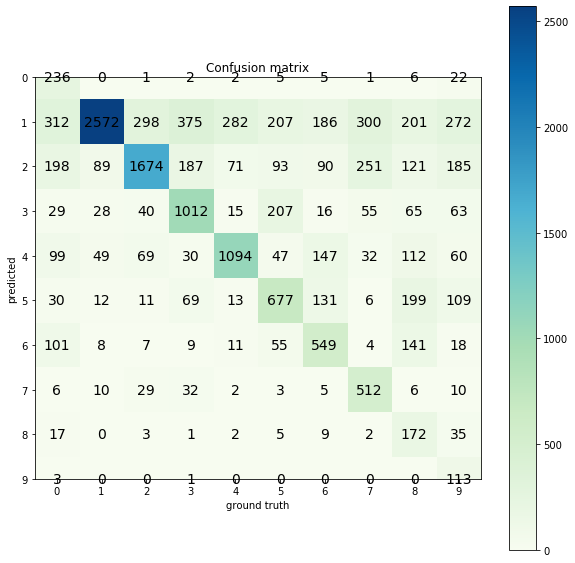

In [27]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    
    for i in range(10):
        for j in range(10):       
            confusion_matrix[i,j] = np.sum(predictions[ground_truth == j] == i)
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

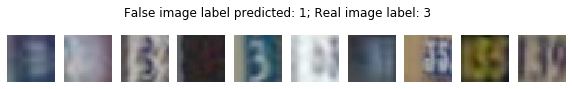

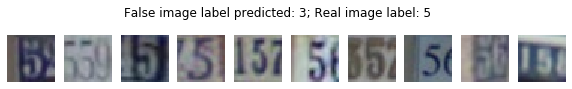

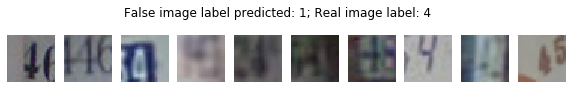

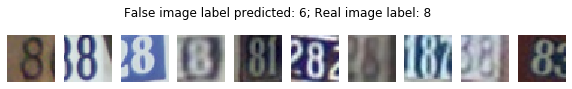

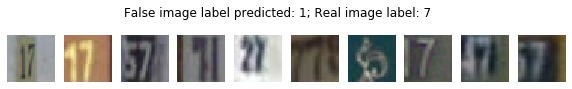

In [28]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    img_ind = val_indices[(ground_truth == gt_class) & (predictions == predicted_class)]
    title = 'False image label predicted: ' + str(predicted_class) + '; Real image label: ' + str(gt_class)
    visualize_images(img_ind, data, title=title, max_num=10)
    return


visualize_predicted_actual(1, 3, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(3, 5, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 4, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

In [29]:
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.ReLU(inplace=True),
   
    nn.Linear(100, 100),
    nn.BatchNorm1d(100), #Batch Normalization 
    nn.ReLU(inplace=True),
    
    nn.Linear(100, 10),  
    nn.BatchNorm1d(10), #Batch Normalization
         )



optimizer = optim.Adam(nn_model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)


loss_history, train_history, val_history = train_model_sch(nn_model, train_loader, val_loader, loss, optimizer, 15, scheduler)

Average loss: 1.509336, Train accuracy: 0.516978, Val accuracy: 0.641526
Average loss: 1.174321, Train accuracy: 0.638040, Val accuracy: 0.658726
Average loss: 0.989339, Train accuracy: 0.703307, Val accuracy: 0.712102
Average loss: 0.934174, Train accuracy: 0.721360, Val accuracy: 0.737288
Average loss: 0.822904, Train accuracy: 0.757926, Val accuracy: 0.771210
Average loss: 0.791761, Train accuracy: 0.769290, Val accuracy: 0.774759
Average loss: 0.722319, Train accuracy: 0.791472, Val accuracy: 0.799399
Average loss: 0.707942, Train accuracy: 0.797700, Val accuracy: 0.805269
Average loss: 0.662686, Train accuracy: 0.811828, Val accuracy: 0.814620
Average loss: 0.647404, Train accuracy: 0.817101, Val accuracy: 0.812641
Average loss: 0.623111, Train accuracy: 0.827475, Val accuracy: 0.819944
Average loss: 0.615742, Train accuracy: 0.828072, Val accuracy: 0.822060
Average loss: 0.600692, Train accuracy: 0.834880, Val accuracy: 0.826087
Average loss: 0.594115, Train accuracy: 0.837559, V

In [30]:
#test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8060
